# 1. Import Library


In [1]:
import os
import cv2
import keras
import random
import pathlib
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import matplotlib.image as mpimg


from keras import Input
from keras.utils import to_categorical
from keras.preprocessing import image
from keras.preprocessing.image import ImageDataGenerator
from sklearn.metrics import confusion_matrix
from sklearn.metrics import classification_report
from sklearn.model_selection import train_test_split

# 2. Data Understanding


In [2]:
base_path = "./dataset/fruits-skripsi/"

train_path = pathlib.Path("./dataset/fruits-skripsi/Training/")
test_path = pathlib.Path("./dataset/fruits-skripsi/Test/")

filepaths = []
labels = []
fruit_names = []
total_image = 0

classlist = os.listdir(train_path)
for kelas in classlist:
    kelaspath = os.path.join(train_path, kelas)
    classes = os.path.basename(kelaspath)
    fruit_names.append(classes)
    if os.path.isdir(kelaspath):
        flist = os.listdir(kelaspath)
        for f in flist:
            fpath = os.path.join(kelaspath, f)
            filepaths.append(fpath)
            labels.append(kelas)
        total_image += len(flist)

classlist = os.listdir(test_path)
for kelas in classlist:
    kelaspath = os.path.join(test_path, kelas)
    if os.path.isdir(kelaspath):
        flist = os.listdir(kelaspath)
        for f in flist:
            fpath = os.path.join(kelaspath, f)
            filepaths.append(fpath)
            labels.append(kelas)
        total_image += len(flist)


Fseries = pd.Series(filepaths, name="filepaths")
Lseries = pd.Series(labels, name="labels")
df = pd.concat([Fseries, Lseries], axis=1)


# Menampilkan tabel dengan jumlah label
label_counts = df["labels"].value_counts().reset_index()
label_counts.columns = ["Labels", "Jumlah"]
print(label_counts)

# Menampilkan total jumlah gambar
print("\nTotal Image : ", total_image)

       Labels  Jumlah
0       Grape    1312
1       Apple     656
2      Banana     656
3       Guava     656
4       Mango     656
5    Rambutan     656
6       Salak     652
7      Orange     639
8  Watermelon     632
9     Avocado     570

Total Image :  7085


In [3]:
# Training
np.random.seed(1234)
directory_train = train_path

all_arrays_train = []
img_size = 100
for i in fruit_names:
    path = os.path.join(directory_train, i)
    class_num = fruit_names.index(i)
    for img in os.listdir(path):
        img_array_train = cv2.imread(os.path.join(path, img))
        img_array_train = cv2.cvtColor(img_array_train, cv2.COLOR_BGR2RGB)
        all_arrays_train.append([img_array_train, class_num])

# Test
np.random.seed(1234)
directory_test = test_path

all_arrays_test = []
img_size = 100
for i in fruit_names:
    path = os.path.join(directory_test, i)
    class_num = fruit_names.index(i)
    for img in os.listdir(path):
        img_array_test = cv2.imread(os.path.join(path, img))
        img_array_test = cv2.cvtColor(img_array_test, cv2.COLOR_BGR2RGB)
        all_arrays_test.append([img_array_test, class_num])

# 3. Image Preprocessing


In [4]:
random.shuffle(all_arrays_train)

X_train = []
Y_train = []
for features, label in all_arrays_train:
    X_train.append(features)
    Y_train.append(label)
X_train = np.array(X_train)  # arraying

random.shuffle(all_arrays_test)

X_test = []
Y_test = []
for features, label in all_arrays_test:
    X_test.append(features)
    Y_test.append(label)
X_test = np.array(X_test)  # arraying

In [5]:
X_train = X_train.reshape(-1, img_size, img_size, 3)
X_train = X_train / 255
X_test = X_test.reshape(-1, img_size, img_size, 3)
X_test = X_test / 255
print("Shape X_train    = ", X_train.shape)
print("Shape X_test     = ", X_test.shape)

Shape X_train    =  (5309, 100, 100, 3)
Shape X_test     =  (1776, 100, 100, 3)


In [6]:
Y_train = to_categorical(Y_train, num_classes=10)
Y_test = to_categorical(Y_test, num_classes=10)

In [7]:
Y_train.shape

(5309, 10)

In [8]:
X_train.shape

(5309, 100, 100, 3)

In [9]:
x_train, x_val, y_train, y_val = train_test_split(
    X_train, Y_train, test_size=0.4, random_state=42
)

print("Total image x_train : ", len(x_train))
print("Total image x_val : ", len(x_val))
print("Total image y_train : ", len(y_train))
print("Total image y_val : ", len(y_val))

Total image x_train :  3185
Total image x_val :  2124
Total image y_train :  3185
Total image y_val :  2124


# 4. Image Augmentation


In [10]:
datagen = ImageDataGenerator(
    rotation_range=1,
    zoom_range=0.5,
    width_shift_range=0.5,
    height_shift_range=0.5,
)

datagen.fit(x_train)

# 5. Model CNN Sequential


In [11]:
model = keras.Sequential(
    [
        keras.Input(shape=(100, 100, 3)),
        keras.layers.Conv2D(16, 5, activation="relu"),
        keras.layers.MaxPooling2D(2, strides=2),
        keras.layers.Conv2D(32, 5, activation="relu"),
        keras.layers.MaxPooling2D(2, strides=2),
        keras.layers.Conv2D(64, 5, activation="relu"),
        keras.layers.MaxPooling2D(2, strides=2),
        keras.layers.Conv2D(128, 5, activation="relu"),
        keras.layers.MaxPooling2D(2, strides=2),
        keras.layers.Dropout(0.5),
        keras.layers.Flatten(),
        keras.layers.Dense(1024, activation="relu"),
        keras.layers.Dropout(0.5),
        keras.layers.Dense(10, activation="softmax"),
    ]
)

model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 96, 96, 16)        1216      
                                                                 
 max_pooling2d (MaxPooling2  (None, 48, 48, 16)        0         
 D)                                                              
                                                                 
 conv2d_1 (Conv2D)           (None, 44, 44, 32)        12832     
                                                                 
 max_pooling2d_1 (MaxPoolin  (None, 22, 22, 32)        0         
 g2D)                                                            
                                                                 
 conv2d_2 (Conv2D)           (None, 18, 18, 64)        51264     
                                                                 
 max_pooling2d_2 (MaxPoolin  (None, 9, 9, 64)          

In [12]:
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=0.001),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

callback = keras.callbacks.EarlyStopping(
    monitor="loss", patience=5, restore_best_weights=True
)

history = model.fit(
    datagen.flow(x_train, y_train, batch_size=20),
    steps_per_epoch=56,
    validation_data=(x_val, y_val),
    validation_steps=20,
    epochs=10,
    callbacks=[callback],
    verbose=1,
)

Epoch 1/10


56/56 [==============================] - 15s 236ms/step - loss: 2.1434 - accuracy: 0.2271 - val_loss: 1.7222 - val_accuracy: 0.2773
Epoch 2/10
56/56 [==============================] - 11s 196ms/step - loss: 1.6084 - accuracy: 0.3187 - val_loss: 1.2879 - val_accuracy: 0.4976
Epoch 3/10
56/56 [==============================] - 15s 276ms/step - loss: 1.2608 - accuracy: 0.4679 - val_loss: 1.0798 - val_accuracy: 0.5080
Epoch 4/10
56/56 [==============================] - 16s 282ms/step - loss: 0.9279 - accuracy: 0.6330 - val_loss: 0.4577 - val_accuracy: 0.8917
Epoch 5/10
56/56 [==============================] - 13s 239ms/step - loss: 0.6654 - accuracy: 0.7312 - val_loss: 0.3572 - val_accuracy: 0.8898
Epoch 6/10
56/56 [==============================] - 10s 175ms/step - loss: 0.6242 - accuracy: 0.7777 - val_loss: 0.1584 - val_accuracy: 0.9642
Epoch 7/10
56/56 [==============================] - 11s 193ms/step - loss: 0.5222 - accuracy: 0.8054 - val_loss: 0.2730 - val_accuracy: 0.92

In [13]:
loss, acc = model.evaluate(x_val, y_val)
print("Accuracy : {:5.2f}%".format(100 * acc))

67/67 [==============================] - 3s 38ms/step - loss: 0.1100 - accuracy: 0.9628
Accuracy : 96.28%


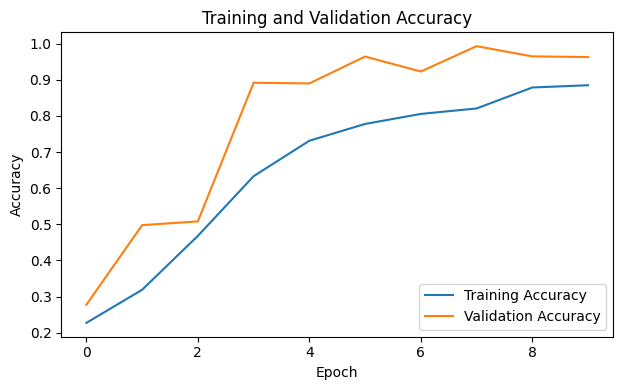

In [14]:
# Plot Accuracy
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history["accuracy"], label="Training Accuracy")
plt.plot(history.history["val_accuracy"], label="Validation Accuracy")
plt.title("Training and Validation Accuracy")
plt.xlabel("Epoch")
plt.ylabel("Accuracy")
plt.legend()

plt.tight_layout()
plt.show()

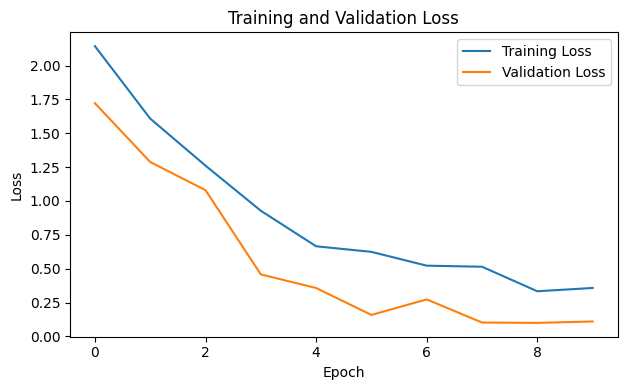

In [15]:
# Plot Loss
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 2)
plt.plot(history.history["loss"], label="Training Loss")
plt.plot(history.history["val_loss"], label="Validation Loss")
plt.title("Training and Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

plt.tight_layout()
plt.show()

In [16]:
predictions = model.predict(X_test)
predicted_classes = np.argmax(predictions, axis=1)
true_classes = np.argmax(Y_test, axis=1)

56/56 [==============================] - 2s 39ms/step


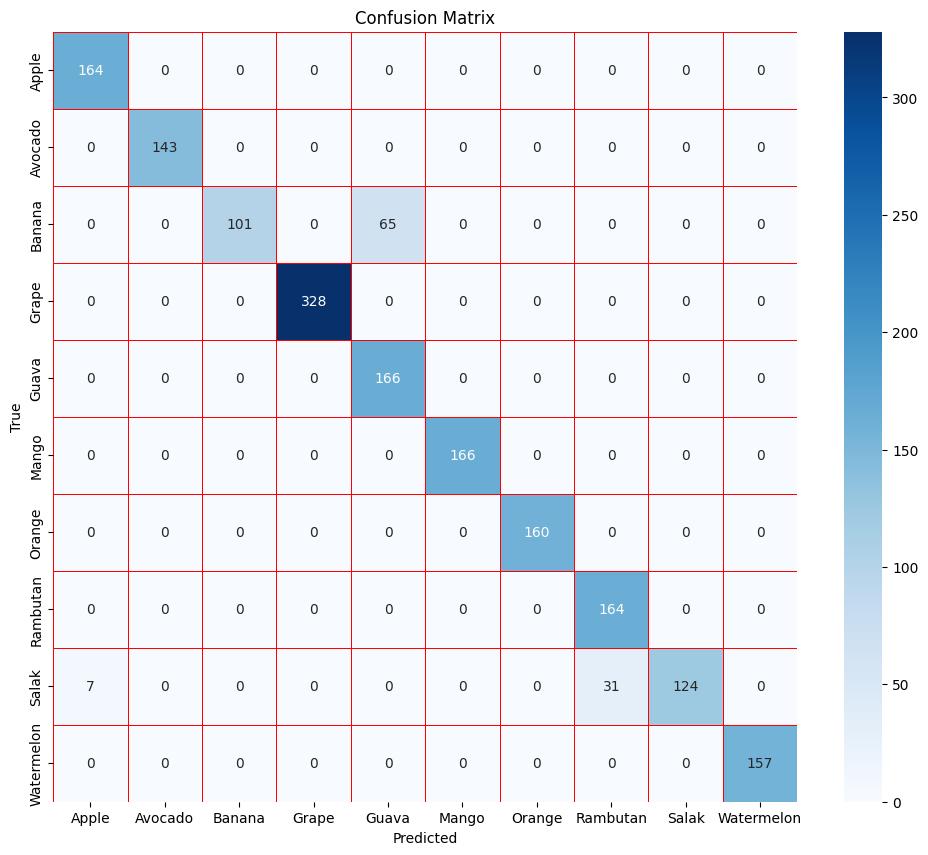

In [17]:
cm = confusion_matrix(true_classes, predicted_classes)
# Menampilkan Confusion Matrix dengan seaborn
plt.figure(figsize=(12, 10))
sns.heatmap(
    cm,
    annot=True,
    fmt="d",
    cmap="Blues",
    linewidths=0.5,
    linecolor="red",
    xticklabels=fruit_names,
    yticklabels=fruit_names,
)
plt.title("Confusion Matrix")
plt.xlabel("Predicted")
plt.ylabel("True")
plt.show()

In [18]:
report = classification_report(
    true_classes, predicted_classes, target_names=fruit_names
)

# Menampilkan Classification Report
print("Classification Report:\n\n", report)

Classification Report:

               precision    recall  f1-score   support

       Apple       0.96      1.00      0.98       164
     Avocado       1.00      1.00      1.00       143
      Banana       1.00      0.61      0.76       166
       Grape       1.00      1.00      1.00       328
       Guava       0.72      1.00      0.84       166
       Mango       1.00      1.00      1.00       166
      Orange       1.00      1.00      1.00       160
    Rambutan       0.84      1.00      0.91       164
       Salak       1.00      0.77      0.87       162
  Watermelon       1.00      1.00      1.00       157

    accuracy                           0.94      1776
   macro avg       0.95      0.94      0.94      1776
weighted avg       0.96      0.94      0.94      1776



1/1 [==============================] - 0s 52ms/step


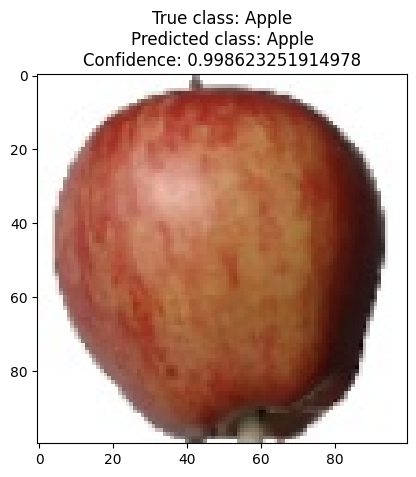

In [19]:
test_data = "./dataset/fruits-skripsi/Training/Apple/10_100.jpg"
true_class = os.path.basename(os.path.dirname(test_data))
test_img = image.load_img(test_data, target_size=(100, 100))
img_arr = image.img_to_array(test_img)
img_arr = np.expand_dims(img_arr, axis=0)
img_arr /= 255.0

prediksi = model.predict(img_arr)
hasil_prediksi = fruit_names[np.argmax(prediksi)]

# Menampilkan gambar
img = mpimg.imread(test_data)
imgplot = plt.imshow(img)
plt.title(
    f"True class: {true_class}\nPredicted class: {hasil_prediksi}\nConfidence: {prediksi[0][np.argmax(prediksi)]}"
)
plt.show()

In [20]:
model.save("./webapps/model/60-40/Model-Skripsi_96.h5")
model.save("./webapps/model/60-40/Model-Skripsi_96.keras")

d:\Farhantu\Kepentingan\Sskkrrippsiiissss\Code\.venv\Lib\site-packages\keras\src\engine\training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


In [21]:
model_path = "./webapps/model/60-40/Model-Skripsi_96.h5"
modelLoad = keras.models.load_model(model_path)
print(modelLoad)

model_path2 = "./webapps/model/60-40/Model-Skripsi_96.keras"
modelLoad2 = keras.models.load_model(model_path2)
print(modelLoad2)